In [0]:
# http://pytorch.org/
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.3.0.post4-{platform}-linux_x86_64.whl torchvision
import torch

In [0]:
import copy
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import cv2, random
import matplotlib.pyplot as plt

import torchvision.datasets as dset
import torchvision.transforms as T

import numpy as np

import timeit





In [0]:

# !pip install Pillow==4.0.0
# !pip install PIL
# !pip install image
# import PIL.image

In [3]:
# Verify that CUDA is properly configured and you have a GPU available

torch.cuda.is_available()

True

In [5]:
from google.colab import files

uploaded = files.upload() # this line will let you select path to upload file 

Saving smol_batch_val.zip to smol_batch_val.zip


In [10]:
!ls
# check to see if the zip file get uploaded or not

datalab   smol_batch	  smol_batch_val.zip  wellnt
__MACOSX  smol_batch_val  smol_batch.zip      wellnt.zip


In [0]:
# !unzip smol_batch.zip # train data
# !unzip wellnt.zip # test data
# !unzip smol_batch_val.zip # val data

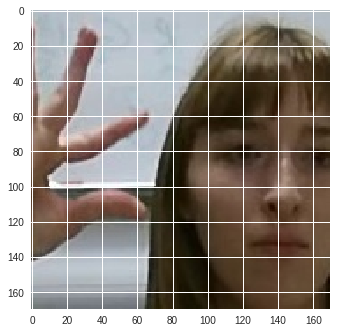

In [8]:
# test to show the image
plt.figure()
image = cv2.imread('wellnt/038_1673_28.jpg')
# openCV uses a different color scheme, change it back to RGB for plotting
RGB_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(RGB_img)
plt.show()



In [9]:
# check the type and shape of the image
print (type(image))
image.shape

# should be 170 x 170 x 3

<class 'numpy.ndarray'>


(170, 170, 3)

In [0]:
# class ChunkSampler(sampler.Sampler):
#     """Samples elements sequentially from some offset. 
#     Arguments:
#         num_samples: # of desired datapoints
#         start: offset where we should start selecting from
#     """
#     def __init__(self, num_samples, start = 0):
#         self.num_samples = num_samples
#         self.start = start

#     def __iter__(self):
#         return iter(range(self.start, self.start + self.num_samples))

#     def __len__(self):
#         return self.num_samples

# NUM_TRAIN = 2000
# NUM_VAL = 100

In [0]:
# converting the directories into torch.dataset
# transform_test = T.Compose([
#     T.Resize((170, 170)),
#     T.ToTensor(),
# ])

# from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
# data = ImageFolder(root='main_dir', transform=ToTensor())


hand_train = dset.ImageFolder(root='smol_batch', transform=ToTensor())

loader_train = DataLoader(hand_train, shuffle=True)

hand_val = dset.ImageFolder(root='smol_batch_val',  transform=ToTensor())

loader_val = DataLoader(hand_val, shuffle=True)


In [14]:
print (hand_val.classes) # print out classes in our data set, should print out 
#0 and 1, 0 for no hand and 1 for yes hand

['0', '1']


In [35]:
noHand = 0
hand = 0
for i in range(len(hand_train)):
    x,y = hand_train[i]
    if y == 1:
      hand += 1
    else:
      noHand +=1
print("Number of data point of class hand: ",hand)
print("Number of data point of class no hand: ", noHand)
# check if we have the right amount of data points in each class
# should print 17,712 for hand and 11,731 for no hand

Number of data point of class hand:  17712
Number of data point of class no hand:  11731


In [0]:
# train method declaration
def train(model, loss_fn, optimizer, num_epochs = 1):
    for epoch in range(num_epochs):
        print('Starting epoch %d / %d' % (epoch + 1, num_epochs))
        model.train()
        for t, (x, y) in enumerate(loader_train):
            x_var = Variable(x.type(gpu_dtype))
            y_var = Variable(y.type(gpu_dtype).long())

            scores = model(x_var)
            
            loss = loss_fn(scores, y_var)
            if (t + 1) % print_every == 0:
                print('t = %d, loss = %.4f' % (t + 1, loss.data[0]))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

# check accuracy method
def check_accuracy(model, loader):
    num_correct = 0
    num_samples = 0
    model.eval() # Put the model in test mode (the opposite of model.train(), essentially)
    for x, y in loader:
        x_var = Variable(x.type(gpu_dtype), volatile=True)

        scores = model(x_var)
#         print (scores)
        _, preds = scores.data.cpu().max(1)
        
        num_correct += (preds == y).sum()
        num_samples += preds.size(0)
    acc = float(num_correct) / num_samples
    
    print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
    return 100 * acc


# This is a little utility that we'll use to reset the model
# if we want to re-initialize all our parameters
def reset(m):
    if hasattr(m, 'reset_parameters'):
        m.reset_parameters()
        
        
# define the flatten class
class Flatten(nn.Module):
    def forward(self, x):
        N, C, H, W = x.size() # read in N, C, H, W
        return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

In [18]:
# control how often we print out the loss
print_every = 100

# select gpu data type
gpu_dtype = torch.cuda.FloatTensor

simple_model = nn.Sequential(
                # N x 3 x 170 x 170
                nn.Conv2d(3, 32, kernel_size=3, stride=1,padding =1),
                nn.BatchNorm2d(32), 
    
                nn.MaxPool2d(2, stride = 2), # N x 32 x 85 x 85
    
                # N x 32 x 85 x 85
                nn.Conv2d(32, 64, kernel_size=3, stride=1,padding =1),
                nn.BatchNorm2d(64), 
    
                nn.MaxPool2d(2, stride = 2), # N x 64 x 42 x 42
    
    
    
                nn.Dropout2d(p=0.2),
    
    
    
                # N x 64 x 42 x 42
                nn.Conv2d(64, 128, kernel_size=3, stride=1,padding =1),
                nn.BatchNorm2d(128), 
    
                nn.MaxPool2d(2, stride = 2), # N x 128 x 21 x 21
    
                # N x 128 x 21 x 21
                nn.Conv2d(128, 256, kernel_size=3, stride=1,padding =1),
                nn.BatchNorm2d(256), 
    
                nn.MaxPool2d(2, stride = 2), # N x 256 x 10 x 10
    
    
                Flatten(), # N x 25600
                nn.Linear(25600, 4096),
                nn.ReLU(inplace=True),
                nn.Linear(4096, 2),
                nn.Softmax(dim=1),
              ) 
      
print ("Success")

Success


In [36]:
# reset the parameters !!
model_gpu.apply(reset)

Sequential(
  (0): Conv2d (3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
  (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (3): Conv2d (32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (6): Dropout2d(p=0.2)
  (7): Conv2d (64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
  (9): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (10): Conv2d (128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
  (12): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (13): Flatten(
  )
  (14): Linear(in_features=25600, out_features=4096)
  (15): ReLU(inplace)
  (16): Linear(in_features=4096, out_features

In [0]:
# transform the model into gpu capable
model_gpu = copy.deepcopy(simple_model).type(gpu_dtype)

# declare loss function and optimizer
loss_fn = nn.CrossEntropyLoss().type(gpu_dtype)

# declare optimizer
optimizer = optim.Adam(model_gpu.parameters(), lr=1e-5) # can change the learning rate here 

train(model_gpu, loss_fn, optimizer, num_epochs=1)

acc = check_accuracy(model_gpu, loader_val)

print (acc)

In [38]:
acc = check_accuracy(model_gpu, loader_val)


Got 510 / 528 correct (96.59)


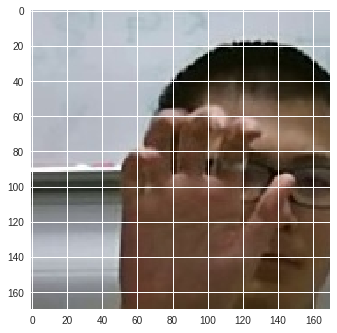

Model predict:  
 0
[torch.LongTensor of size 1]



In [44]:
# Manual testing!
# read in an image and print out which class it predict (1 for patch with hands, 0 otherwise)

image2 = cv2.imread('wellnt/066_1175_28.jpg')

# show the image
plt.figure()
# openCV uses a different color scheme, change it back to RGB for plotting
RGB_img = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)
plt.imshow(RGB_img)
plt.show()

model_gpu.eval()
a2 = image2
test2 = torch.from_numpy(a2)  # convert the numpy array into torch tensor
test2 = test2.unsqueeze(0) # add another dimension to the torch
test2 = test2.permute(0, 3, 1, 2) # rearrange the axis to match the model
x_var2 = Variable(test2.type(gpu_dtype)) # convert into a variable to feed into the model
scores2 = model_gpu(x_var2) # get the score for this prediction
_, preds = scores2.data.cpu().max(1) # get the predictions (should be either class 0 or class 1)
print ("Model predict: ", preds)